# Training quantum embedding kernels for classification

In this tutorial we will dive deeper into the the concept of quantum embedding kernels, or quantum kernels. We will train a quantum kernel based on a similarity measure called the kernel-target alignment and see how the training improves the performance of it as a classifier. We will demonstrate how to use Covalent to orchestrate the whole workflow composed of multiple smaller subtasks. Once the workflow is dispatched, we will be able to track the results of each subtask through the Covalent result manager. In the meantime, all the subtasks constructed can be called as normal Python functions, giving users more flexibility in testing and debugging. For more details about the quantum embedding kernels, we refer the reader to this PennyLane demo: [Training and evaluating quantum kernels](https://pennylane.ai/qml/demos/tutorial_kernels_module.html#training-qeks), which this tutorial is based on.

In addition to Covalent, one first needs to install the following packages in order to fully reproduce the results of this tutorial.

In [ ]:
# !pip install pennylane==0.23.1
# !pip install scikit-learn==1.1.1
# !pip install matplotlib==3.5.1
# !pip install covalent-dask-plugin

Let us begin by starting the Covalent server and importing the necessary packages.

In [12]:
# !covalent start

In [15]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
from covalent.executor import DaskExecutor
from dask.distributed import LocalCluster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

cluster = LocalCluster(processes=True)
dask_executor = DaskExecutor(scheduler_address=cluster.scheduler_address)

np.random.seed(2022)

## Defining the quantum kernel

We first generate a dataset with two features and two classes for our classification task using `scikit-learn`'s `make_classification` function. The dataset contains 20 randomly generated points, with 10 in each class. We then do a train/test split with a ratio of 8:2. Moreover, we include the above two steps in the Covalent workflow as subtasks by adding the `electron` decorator on top of the respective functions.

In [33]:
@ct.electron
def get_data():
    X, y = make_classification(
        n_samples=20, n_features=2, n_redundant=0, random_state=42, n_clusters_per_class=2, flip_y=0.2
    )
    X = X.astype(np.float32)
    y = 2 * (y - 0.5) # rescale labels to be -1, 1
    y = y.astype(int)
    return X, y

@ct.electron
def split_train_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    return X_train, X_test, y_train, y_test

As mentioned at the beginning, these subtasks can be called as normal Python functions. So we can plot the dataset for visualization.

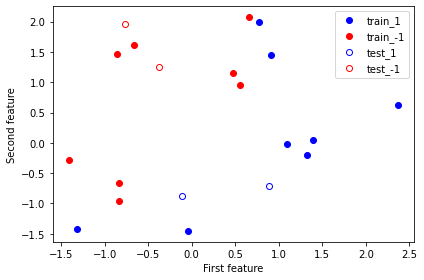

In [34]:
X, y = get_data()
X_train, X_test, y_train, y_test = split_train_test_data(X, y)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor="w")
ax.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="train_1")
ax.plot(X_train[:, 0][y_train==-1], X_train[:, 1][y_train==-1], "ro", label="train_-1")
ax.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], "bo", fillstyle='none', label="test_1")
ax.plot(X_test[:, 0][y_test==-1], X_test[:, 1][y_test==-1], "ro", fillstyle='none', label="test_-1")
ax.set_xlabel("First feature")
ax.set_ylabel("Second feature")
plt.tight_layout()
plt.legend()
plt.show()

Next, we construct the quantum embedding kernel by building a *data reuploading* quantum circuit based on the ansatz given in [Hubregtsen et al. 2021](https://arxiv.org/abs/2105.02276). Specifically, this ansatz uses a repeating layer architecture, where each layer embeds the two features into five qubits through the angles of $R_Z$ gates. The variational parameters correspond the angles of a series of $R_Y$ and controlled-$R_Z$ gates. The circuit diagram of one layer is shown below.